In [1]:
#Read in all of the relevant libraries
import numpy as np
import pandas as pd  #Pandas is a nice package for data reading/selection
import math
import scipy as sp
import matplotlib.pyplot as plt
import ellipses as el

from IPython.display import display
import sys
import pickle
import seaborn
seaborn.set_style('ticks')
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

This notebook is for postprocessing the large numbers of simulations we run with the metapopulations code. It takes a list of file names, reads in those simulations, then can calculate various quantities from those simulations to generate output figures. 

In [2]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

In [90]:
#Take a list of files to generate an output for that list. Will be nxm long, where n and m are the number of sims
#for each of the parameters you've looped over (need to tell it n and m)You'll need to set up the filenames so that 
#they actually go in the order you want. 
#to make filelist: ls -1 *.csv | sort -t'_' -n -k2 > filelist.txt
filenames = pd.read_csv('../Sims/test2/filelist.txt',delim_whitespace=True,header=None)
n = 5  #points along first parameter
m = 5  #points along second parameter

In [91]:
#Getting the file names in a workable format
filemat = filenames.values
filemat = filemat.flatten()
npoint = len(filemat)/4
filemat = filemat.reshape([npoint,4])
print filemat[0:n*m,0]

['cases_0_vaxvar0.2_popvar0.7_pop5000.0_0.csv'
 'cases_1_vaxvar0.2_popvar0.75_pop5000.0_0.csv'
 'cases_2_vaxvar0.2_popvar0.8_pop5000.0_0.csv'
 'cases_3_vaxvar0.2_popvar0.85_pop5000.0_0.csv'
 'cases_4_vaxvar0.2_popvar0.9_pop5000.0_0.csv'
 'cases_5_vaxvar0.2_popvar0.7_pop28750.0_0.csv'
 'cases_6_vaxvar0.2_popvar0.75_pop28750.0_0.csv'
 'cases_7_vaxvar0.2_popvar0.8_pop28750.0_0.csv'
 'cases_8_vaxvar0.2_popvar0.85_pop28750.0_0.csv'
 'cases_9_vaxvar0.2_popvar0.9_pop28750.0_0.csv'
 'cases_10_vaxvar0.2_popvar0.7_pop52500.0_0.csv'
 'cases_11_vaxvar0.2_popvar0.75_pop52500.0_0.csv'
 'cases_12_vaxvar0.2_popvar0.8_pop52500.0_0.csv'
 'cases_13_vaxvar0.2_popvar0.85_pop52500.0_0.csv'
 'cases_14_vaxvar0.2_popvar0.9_pop52500.0_0.csv'
 'cases_15_vaxvar0.2_popvar0.7_pop76250.0_0.csv'
 'cases_16_vaxvar0.2_popvar0.75_pop76250.0_0.csv'
 'cases_17_vaxvar0.2_popvar0.8_pop76250.0_0.csv'
 'cases_18_vaxvar0.2_popvar0.85_pop76250.0_0.csv'
 'cases_19_vaxvar0.2_popvar0.9_pop76250.0_0.csv'
 'cases_20_vaxvar0.2_popvar

In [92]:
#'toplot' is the variable that you'll be calculating in order to generate a color map. 
# options: nigh, Ipercent, and ellipse
toplot = 'Nhigh'  
#set up a matrix to hold the values of this variable:
plotmat = np.zeros([n,m])

In [93]:
#Select the subset of files you're going to work with (mostly for testing purposes):
'''
files_subset = []
for i in range(n):
    files_subset.append(filemat[:,n*m*i:n*m*(i+1)])
'''
#files_subset now contains nxm (x4, since there are I,S,R,and V files for each sim) 
#files for each of 10 different vaccination variance levels. If you want to make a grid looping over vacc. variance,
#you'll have to change the code quite a bit.

'\nfiles_subset = []\nfor i in range(n):\n    files_subset.append(filemat[:,n*m*i:n*m*(i+1)])\n'

In [94]:
#Select all files with the same vacc. variance.
#files = files_subset[4]
choose = 4 #which vacc. variance do you want to look at? Starts at 1, not 0.
files = filemat[n*m*(choose-1):n*m*choose,:]
print np.shape(files)
print files[0,0]

(25, 4)
cases_75_vaxvar0.5_popvar0.7_pop5000.0_0.csv


In [95]:
#This loop reads through all of the files and calculates the output variable, storing it in the plotmat matrix.
for i in range(n):
    print i
    for j in range(m):
        #Read in data file
        filenum = i*n+j%m
        print files[filenum,0]
        

        Ifile = pd.read_csv('../Sims/test2/'+files[filenum,0], delim_whitespace=True,header=0)
        Sfile = pd.read_csv('../Sims/test2/'+files[filenum,1], delim_whitespace=True,header=0)
        Rfile = pd.read_csv('../Sims/test2/'+files[filenum,2], delim_whitespace=True, header=0)
        Vfile = pd.read_csv('../Sims/test2/'+files[filenum,3], delim_whitespace=True,header=0)
        
        Idata_all = Ifile.values
        Sdata_all = Sfile.values
        Rdata_all = Rfile.values
        Vdata_all = Vfile.values
                
        Idata_all = Idata_all.astype(float)
        Sdata_all = Sdata_all.astype(float)
        Rdata_all = Rdata_all.astype(float)
        Vdata_all = Vdata_all.astype(float)
        
        tsteps = len(Idata_all[:,0])
        npatch = len(Idata_all[0,:])
        
        burnin = 0.8*len(Idata_all)
        burnin = int(burnin)
        
        Idata = Idata_all[burnin:,:]
        Sdata = Sdata_all[burnin:,:]
        Rdata = Rdata_all[burnin:,:]
        Vdata = Vdata_all[burnin:,:]
        
        '''print j
        if (j-5)%10==0:
            print files[0,filenum]
            plt.plot(Idata)
            '''
        
        #Outbreaks are identified as any string of more than one time-step during which I>0 in a cell.
        if toplot=='Ipercent':
            outsize = np.zeros(npatch)
            k = 1
            while k<(tsteps-burnin):
                for r in range(npatch):
                    if Idata[k,r] > 0.:
                        if Idata[k-1,r] > 0.:
                            outsize[r] += Idata[k,r]
                k += 1

            totinf = sum(outsize)
            totpop = Idata+Sdata+Rdata+Vdata
            totpop = sum(totpop)
            fracinf = outsize/totpop
            print np.shape(outsize)

            plotmat[i,j] = max(fracinf)

        if toplot=='nhigh':
            nhigh = 0
            k = 0
            while k<(tsteps-burnin):
                Ifrac = Idata[k,:]/(Idata[k,:]+Sdata[k,:]+Rdata[k,:]+Vdata[k,:])
                mask = Ifrac>=0.0
                Ihigh = Ifrac[mask]
                x = Ihigh*1.
                nhigh += len(x)
                k+=1
            plotmat[i,j] = nhigh
            
        if toplot=='ellipse':
            nobs = len(Idata)      #How many 'observations'? (i.e. timesteps)
            dates = np.linspace(0,nobs-1,nobs) 
            dates = (dates)%24     #A year is 24 timesteps, in this code. For whatever reason.
            theta = 2.*np.pi*((dates+1)/24.)
            
            eccen = []
            for k in range(400):
                thetafit = theta[:]
                Ifit = Idata[:,k]
                Ifit += 1.
                cartcoords = pol2cart(Ifit,thetafit)
                data = cartcoords

                lsqe = el.LSqEllipse()
                lsqe.fit(data)
                center, width, height, phi = lsqe.parameters()
                if width>height:
                    eccen.append(np.sqrt(1.-(height/width)**2.))
                if height>=width:
                    eccen.append(np.sqrt(1.-(width/height)**2.))
            plotmat[i,j] = np.mean(eccen)
    

0
cases_75_vaxvar0.5_popvar0.7_pop5000.0_0.csv
cases_76_vaxvar0.5_popvar0.75_pop5000.0_0.csv
cases_77_vaxvar0.5_popvar0.8_pop5000.0_0.csv
cases_78_vaxvar0.5_popvar0.85_pop5000.0_0.csv
cases_79_vaxvar0.5_popvar0.9_pop5000.0_0.csv
1
cases_80_vaxvar0.5_popvar0.7_pop28750.0_0.csv
cases_81_vaxvar0.5_popvar0.75_pop28750.0_0.csv
cases_82_vaxvar0.5_popvar0.8_pop28750.0_0.csv
cases_83_vaxvar0.5_popvar0.85_pop28750.0_0.csv
cases_84_vaxvar0.5_popvar0.9_pop28750.0_0.csv
2
cases_85_vaxvar0.5_popvar0.7_pop52500.0_0.csv
cases_86_vaxvar0.5_popvar0.75_pop52500.0_0.csv
cases_87_vaxvar0.5_popvar0.8_pop52500.0_0.csv
cases_88_vaxvar0.5_popvar0.85_pop52500.0_0.csv
cases_89_vaxvar0.5_popvar0.9_pop52500.0_0.csv
3
cases_90_vaxvar0.5_popvar0.7_pop76250.0_0.csv
cases_91_vaxvar0.5_popvar0.75_pop76250.0_0.csv
cases_92_vaxvar0.5_popvar0.8_pop76250.0_0.csv
cases_93_vaxvar0.5_popvar0.85_pop76250.0_0.csv
cases_94_vaxvar0.5_popvar0.9_pop76250.0_0.csv
4
cases_95_vaxvar0.5_popvar0.7_pop100000.0_0.csv
cases_96_vaxvar0.5_p

In [97]:
#Fix the ordering of columns.  i corresponds to popvar, j to popsize. This works for a 10x10 plot
#This is a gross kludge and should be fixed in the above loop instead.

#This should no longer be necessary - the naming conventions have been changed s.t. the files should be in the
#order we want in the filelist.

matrix = plotmat.copy();
'''
holdcol0 = plotmat[:,0].copy()
holdcol1 = plotmat[:,5].copy()

matrix[:,0] = holdcol1               #the fifth column should be the first column
matrix[:,5:9] = plotmat[:,6:].copy() #shift the last few columns left
matrix[:,-1] = holdcol0              #last column replaced with first

holdrow0 = matrix[0,:].copy()
holdrow1 = matrix[1,:].copy()
matrix[0,:] = holdrow1
matrix[1,:] = holdrow0

holdcol0 = plotmat[:,0].copy()
matrix = plotmat.copy()
matrix[:,0:-1] = plotmat[:,1:].copy()
matrix[:,-1] = holdcol0

#matrix[0,:] = holdrow1
#matrix[1,:] = holdrow0
'''

'\nholdcol0 = plotmat[:,0].copy()\nholdcol1 = plotmat[:,5].copy()\n\nmatrix[:,0] = holdcol1               #the fifth column should be the first column\nmatrix[:,5:9] = plotmat[:,6:].copy() #shift the last few columns left\nmatrix[:,-1] = holdcol0              #last column replaced with first\n\nholdrow0 = matrix[0,:].copy()\nholdrow1 = matrix[1,:].copy()\nmatrix[0,:] = holdrow1\nmatrix[1,:] = holdrow0\n\nholdcol0 = plotmat[:,0].copy()\nmatrix = plotmat.copy()\nmatrix[:,0:-1] = plotmat[:,1:].copy()\nmatrix[:,-1] = holdcol0\n\n#matrix[0,:] = holdrow1\n#matrix[1,:] = holdrow0\n'

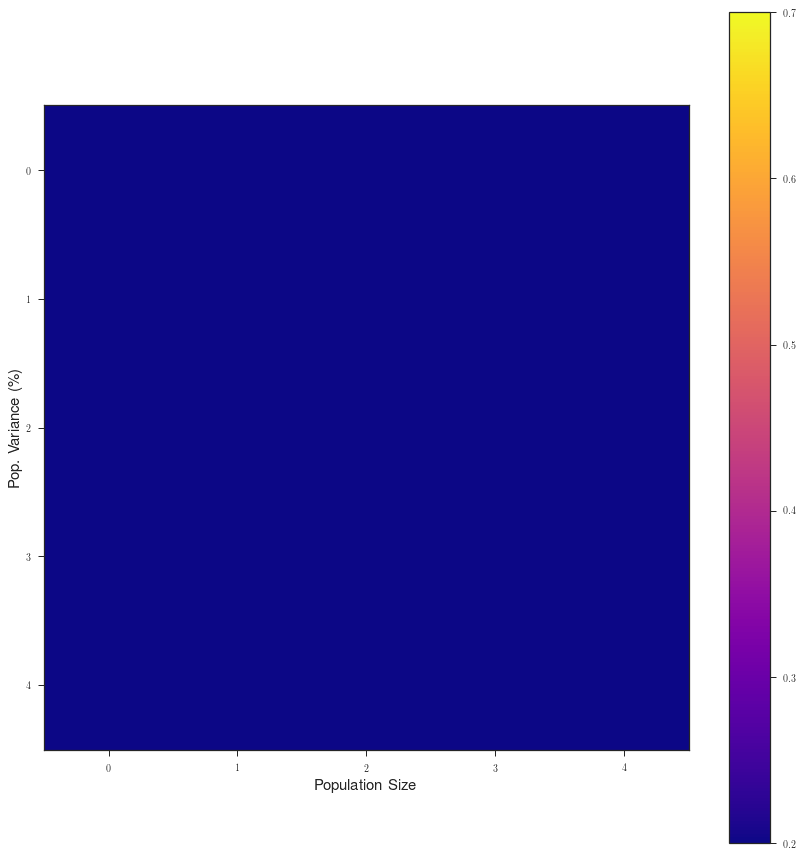

In [98]:
#print out a heatmap of the output variable.
fig, ax = plt.subplots(figsize=(12,12))
cax = ax.imshow((matrix), interpolation='nearest', cmap='plasma',vmin=0.2,vmax=0.7)
ax.set_xticks(np.arange(0,n,1))
ax.set_yticks(np.arange(0,m,1))
#ax.set_xticklabels(['50k','56k','61k','67k','72k','78k','83k','89k','94k','100k'],fontsize=12)
#ax.set_yticklabels([1.0,3.1,5.2,7.3,9.4,11.5,13.7,15.8,17.9,20.],fontsize=12)
ax.set_xlabel('Population Size',fontsize=15)
ax.set_ylabel('Pop. Variance (\%)',fontsize=15)

# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])  # vertically oriented colorbar
fig.tight_layout()

#plt.savefig('../Sims/alpha10c0.1/test.pdf')

In [100]:
#If you just want to plot the timeseries from a single file:
testfile1= pd.read_csv('cases_payload_0.csv',delim_whitespace=True,header=0)
testvals1 = testfile1.values.astype(float)

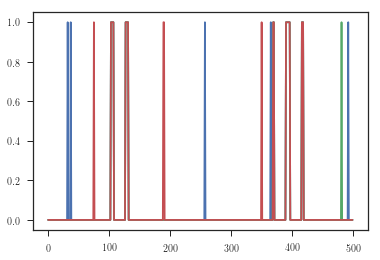

In [102]:
burnin = 9500
plt.plot(testvals1[burnin:,44]);
plt.plot(testvals1[burnin:,80]);
plt.plot(testvals1[burnin:,73]);